In [344]:
from bs4 import BeautifulSoup
import re,string,unicodedata
from string import punctuation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.preprocessing import text, sequence


import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [345]:
df = pd.read_csv("data/NEWS_YAHOO_stock_prediction.csv")
highClose_df = df[['Date','Open','High','Low','Close','Volume']]
#add some technical indicators
# highClose_df['RSI'] = ta.rsi(highClose_df.Close, length=15)
# highClose_df['EMA34_Fast'] = ta.ema(highClose_df.Close, length=34)
# highClose_df['EMA89_Medium'] = ta.ema(highClose_df.Close, length=89)
# highClose_df['EMA200_Slow'] = ta.ema(highClose_df.Close, length=200)
#Target Column is the price change through the day
highClose_df['Target'] = highClose_df['Close'].shift(-1)  - highClose_df['Close']
# highClose_df['Target'] = highClose_df['Target'].shift(-1) 
#Currently, target class means the next day "Bullish" or "Bearish" technically
highClose_df['TargetClass'] = [1 if highClose_df.Target[i] > 0 else 0 for i in range(len(highClose_df))]

# highClose_df['PredictNextClose'] = highClose_df['Close'].shift(-1)
df = pd.concat((df.iloc[:, :2],highClose_df.drop(columns=["Date"])), axis=1).dropna()
df.head(10)

,Date,Titles,Open,High,Low,Close,Volume,Target,TargetClass
0,2016-01-04,Benzinga's Top #PreMarket Gainers Benzinga's T...,103.183176,103.324589,101.929334,103.230316,50807600,-0.179115,0
1,2016-01-05,A Glum View On A High-Flying Sector A Glum Vie...,103.739406,103.871390,102.570407,103.051201,38795200,-0.989899,0
2,2016-01-06,Facebook's WhatsApp To Take On FaceTime And Sk...,101.259973,102.655227,101.259973,102.061302,41891100,-3.195892,0
3,2016-01-07,"Earnings Scheduled For January 7, 2016 Earning...",99.883566,101.146845,98.808840,98.865410,61386300,-0.810753,0
4,2016-01-08,Should Investors Be Worried About Apple? Shoul...,99.581895,100.204109,97.950955,98.054657,69344000,0.301682,1
5,2016-01-11,The Tussle Between Two Big Consumer ETFs Is Te...,98.752289,99.044537,96.847952,98.356339,50024100,1.140717,1
6,2016-01-12,Coty Confirms Transfer of Ten P&amp;G Fragran...,99.299080,100.006137,98.120652,99.497055,46734200,-3.431580,0
7,2016-01-13,Disney's Massive $5.5 Billion Park In Mainland...,99.902438,100.147553,95.914633,96.065475,69870700,2.045761,1
8,2016-01-14,"Walgreens, United Health in Talks to Acquire A...",96.442585,98.969136,94.905910,98.111237,78445700,-3.045082,0
9,2016-01-15,IBM Acquires IRIS Analytics; Terms Not Dislcos...,94.858757,96.103177,93.812312,95.066154,91443900,0.207397,1


In [346]:
df = df[["Titles", "TargetClass"]]

In [347]:
df.shape

(1969, 2)

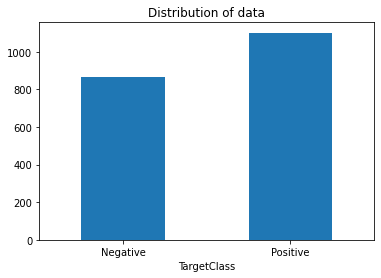

In [348]:
ax = df.groupby('TargetClass').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [349]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [350]:
def decontracted(phrase):
    if "'" in phrase:
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def clean_text(text):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # convert words into lower case
    text= text.lower()
    
    # Replace contraction with their longest forms
    if True:
        text = text.split()
        new_text = []
        # Remove the contractions
        for word in text:
            new_text.append(decontracted(word))
        # Recreate the sentence
        text= ' '.join(new_text)
        
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;','', text)
    text= re.sub(r'0,0','00', text)
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Remove stopwords
    text=text.split()
    stops= set(stopwords.words('english'))
    text = [w for w in text if w not in stops]
    text= " ".join(text)
    
    return text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]#', '', text)
def remove_links(text):
    return re.sub(r'http\S+', '', text)
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
def cleanse_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_links(text)
    text = remove_stopwords(text)
    text = clean_text(text)
    return text

In [351]:
%time
df['Titles']=df['Titles'].apply(cleanse_text)

CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\84866\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [352]:
df['Titles']

0       benzinga top premarket gainers benzinga top pr...
1       glum view high flying sector glum view high fl...
2       facebook whatsapp take facetime skype facebook...
3       earnings scheduled january 7 2016 earnings sch...
4       investors worried apple investors worried appl...
                              ...                        
1964    fear among us investors growing amazon alphabe...
1965    cash rich apple still needs billions catch gen...
1966    steve jobs biographer says apple would amost h...
1967    honeywell likely report higher q3 revenue look...
1968    investor fear grows following earnings economi...
Name: Titles, Length: 1969, dtype: object

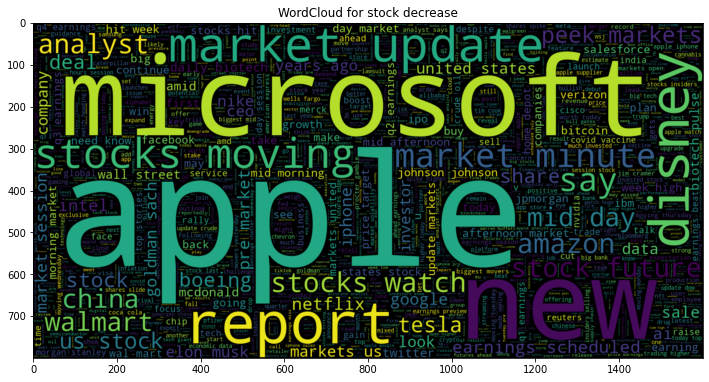

In [353]:
plt.figure(figsize = (12,10)) 
plt.title("WordCloud for stock decrease")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.TargetClass == 0].Titles))
plt.imshow(wc , interpolation = 'bilinear')

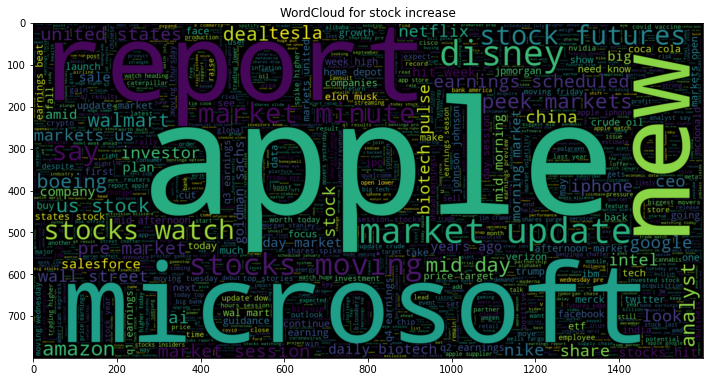

In [354]:
plt.figure(figsize = (12,10)) 
plt.title("WordCloud for stock increase")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.TargetClass == 1].Titles))
plt.imshow(wc , interpolation = 'bilinear')

In [355]:
words = []
for i in df.Titles.values:
    words.append(i.split())
words[:5]

[['benzinga',
  'top',
  'premarket',
  'gainers',
  'benzinga',
  'top',
  'premarket',
  'gainers',
  'benzinga',
  'top',
  'premarket',
  'gainers',
  'head',
  'polls',
  'etf',
  '2016',
  'head',
  'polls',
  'etf',
  '2016',
  'head',
  'polls',
  'etf',
  '2016',
  'head',
  'polls',
  'etf',
  '2016',
  'head',
  'polls',
  'etf',
  '2016',
  'head',
  'polls',
  'etf',
  '2016',
  'download',
  'microsoft',
  'etf',
  'download',
  'microsoft',
  'etf',
  'download',
  'microsoft',
  'etf',
  'download',
  'microsoft',
  'etf',
  'download',
  'microsoft',
  'etf',
  'download',
  'microsoft',
  'etf',
  'dividend',
  'etf',
  'looks',
  'primed',
  'solid',
  '2016',
  'dividend',
  'etf',
  'looks',
  'primed',
  'solid',
  '2016',
  'dividend',
  'etf',
  'looks',
  'primed',
  'solid',
  '2016',
  'dividend',
  'etf',
  'looks',
  'primed',
  'solid',
  '2016',
  'dividend',
  'etf',
  'looks',
  'primed',
  'solid',
  '2016',
  'dividend',
  'etf',
  'looks',
  'primed'

In [356]:
import gensim
EMBEDDING_DIM = 200

In [357]:
%time
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [358]:
len(w2v_model.wv.index_to_key)

19943

In [359]:
from keras.utils import pad_sequences

In [360]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 100)

In [361]:
x

array([[3144,  136,   15, ...,  207,  108,   33],
       [ 623,   43,  292, ...,   42,  401,  344],
       [ 245,   96,   96, ...,  207,  191,   33],
       ...,
       [ 227,  381,   13, ..., 1037, 1073,  436],
       [  98, 1554,   67, ...,  701,  108,  690],
       [ 211,   91,  364, ..., 1974, 7675, 2667]])

In [362]:
x.shape

(1969, 100)

In [363]:
vocab_size = len(tokenizer.word_index) + 1

In [364]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # defining the weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [365]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [366]:
embedding_vectors.shape

(19944, 200)

In [367]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=100, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

del embedding_vectors

c:\Users\84866\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [368]:
x_train, x_test, y_train, y_test = train_test_split(x, df.TargetClass , test_size = 0.3 , random_state = 0, shuffle=False) 

In [369]:
history = model.fit(x_train, y_train, batch_size = 32 , validation_data = (x_test,y_test) , epochs = 10)

Epoch 1/10


44/44 [==============================] - 45s 884ms/step - loss: 0.6914 - accuracy: 0.5588 - val_loss: 0.6971 - val_accuracy: 0.4941
Epoch 2/10
44/44 [==============================] - 47s 1s/step - loss: 0.6779 - accuracy: 0.5864 - val_loss: 0.7007 - val_accuracy: 0.5059
Epoch 3/10
44/44 [==============================] - 48s 1s/step - loss: 0.6567 - accuracy: 0.6270 - val_loss: 0.7041 - val_accuracy: 0.4992
Epoch 4/10
44/44 [==============================] - 55s 1s/step - loss: 0.6200 - accuracy: 0.6640 - val_loss: 0.7744 - val_accuracy: 0.5144
Epoch 5/10
44/44 [==============================] - 48s 1s/step - loss: 0.4366 - accuracy: 0.8142 - val_loss: 0.9785 - val_accuracy: 0.5161
Epoch 6/10
44/44 [==============================] - 47s 1s/step - loss: 0.2258 - accuracy: 0.9144 - val_loss: 1.1421 - val_accuracy: 0.4924
Epoch 7/10
44/44 [==============================] - 43s 995ms/step - loss: 0.0540 - accuracy: 0.9833 - val_loss: 1.3799 - val_accuracy: 0.5059
Epoch 8/10
44/44 [=======

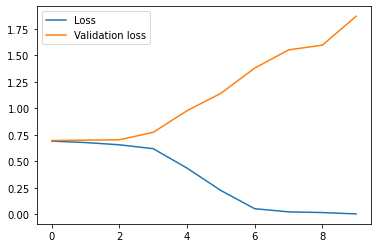

In [370]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

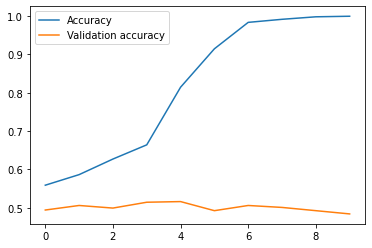

In [371]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()